## Light 2 Numerical and Data Analysis Answers

## 1. Identify Balmer lines

*Author: Kate Storey-Fisher*

Download an optical spectrum of a star forming galaxy. Identify all Balmer emission lines that are apparent in the spectrum. Zooming in on Hα or Hβ, visually compare the Balmer absorption (in the stellar continuum) to the emission.

In [1]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import requests

### Data ###

This is an optical spectrum of a galaxy in SDSS. The data and more info can be found here: https://dr12.sdss.org/spectrumDetail?mjd=53794&fiber=6&plateid=2214

In [2]:
request_template = 'https://dr13.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid={plate}&mjd={mjd}&fiberid={fiberid}'
request = request_template.format(plate=2214, fiberid=6, mjd=53794)
r = requests.get(request)
fp = open('spec-2214-53794-0006.fits', 'wb')
fp.write(r.content)
fp.close()

In [3]:
hdu = fits.open('spec-2214-53794-0006.fits')

In [4]:
header = hdu[0].header
data = hdu[1].data
z = 0.0657799 #Redshift at link above

In [5]:
wl = 10**data['loglam']
flux = data['flux']
model = data['model']

### Balmer Series

The Balmer series are lines due to transitions to the n=2 level of hydrogen. The wavelengths of the first few lines are given below.

The next line, H_epsilon, is outside of the region of our spectrum.

In [6]:
#Balmer series
halpha = 6564.5377
hbeta = 4861.3615
hgamma = 4340.462
hdelta = 4101.74
lines = [halpha, hbeta, hgamma, hdelta]
labels = [r'H$_{\alpha}$', r'H$_{\beta}$', r'H$_{\gamma}$', r'H$_{\delta}$']

Find the wavelength at which the lines are observed, due to redshifting.

In [7]:
#Shifted
lines_shifted = np.empty(len(lines))
for i in range(len(lines)):
    lines_shifted[i] = lines[i]*(1+z)

The H$\alpha$ line is clear, but the others are hard to see when looking at the full spectrum.

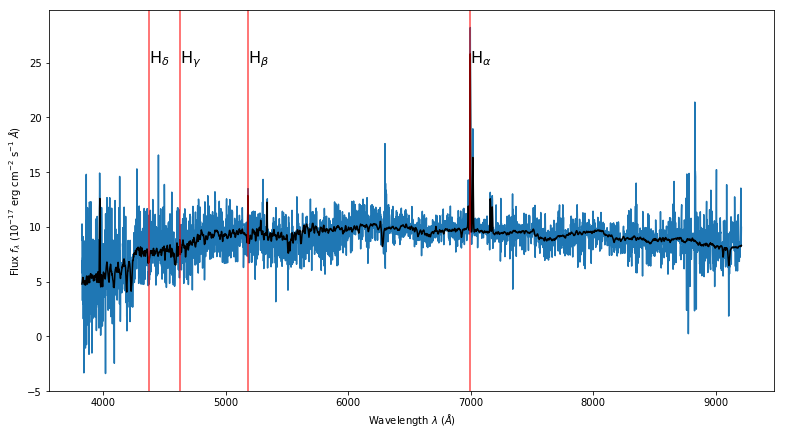

In [8]:
fig = plt.figure(figsize=(13, 7))
plt.plot(wl, flux)
plt.plot(wl, model, color='black')        
plt.xlabel('Wavelength $\lambda$ ($\AA$)')
plt.ylabel('Flux $f_\lambda$ ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA$)')

for line, label in zip(lines_shifted, labels):
    plt.axvline(line, color='red', alpha=0.7)
    plt.annotate(label, xy=(line, 25), xytext=(line, 25), size=16)

### Zooming in

We see that the H$\alpha$ line is very strong, and the H$\beta$ line also has a clear emission peak.
H$\gamma$ and H$\delta$ do not appear to have emission that is significant relative to the noise. The black 
lines in these plots are the model fit by the spectroscopic pipeline in SDSS, so it does not necessarily
faithfully represent the true galaxy spectrum.

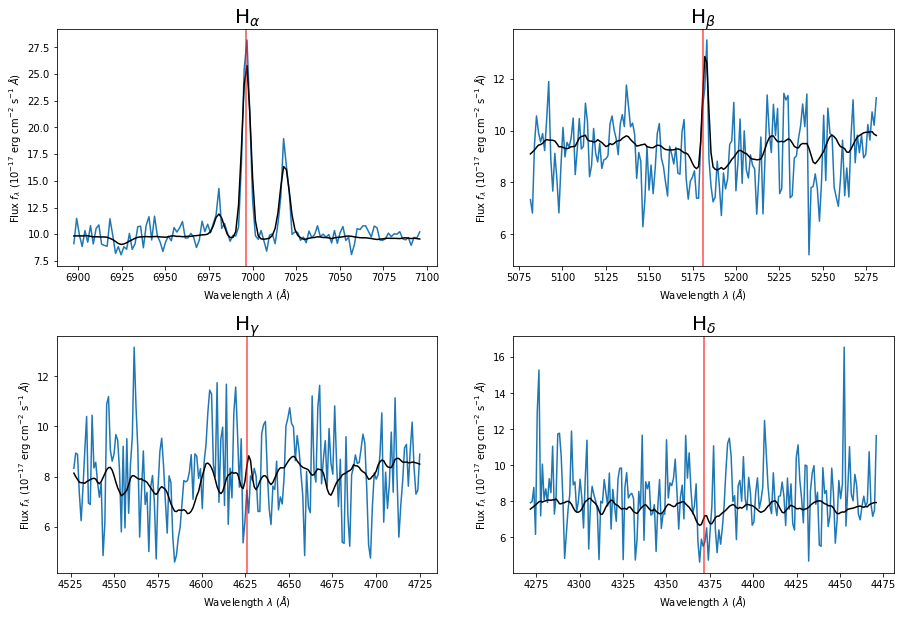

In [9]:
# Zooms
width = 100
fig, axarr = plt.subplots(2,2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)
count = 0
for i in range(2):
    for j in range(2):
        line = lines_shifted[count]
        wf = [(w, f, m) for w, f, m in zip(wl, flux, model) if (w<line+width) and (w>line-width)]
        wlcut = [tup[0] for tup in wf]
        fluxcut = [tup[1] for tup in wf]
        modelcut = [tup[2] for tup in wf]

        axarr[i,j].set_title(labels[count], size=20)
        axarr[i,j].plot(wlcut, fluxcut)
        axarr[i,j].plot(wlcut, modelcut, color='black')
        axarr[i,j].axvline(line, color='red', alpha=0.7)
        axarr[i,j].set_xlabel('Wavelength $\lambda$ ($\AA$)')
        axarr[i,j].set_ylabel('Flux $f_\lambda$ ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA$)')

        count += 1

### Absorption to Emission

Zooming in further on the H$\beta$ line to visually inspect it, the model (black) has clear emission and clear absorption. The absorption is in the underlying stellar continuum spectrum and reflects the presence of neutral, but excited, hydrogen gas in the stellar atmospheres. The absorption feature is believable in the data itself (blue), but it is less obviously real, because of the noise. 

Text(0,0.5,'Flux $f_\\lambda$ ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\\AA$)')

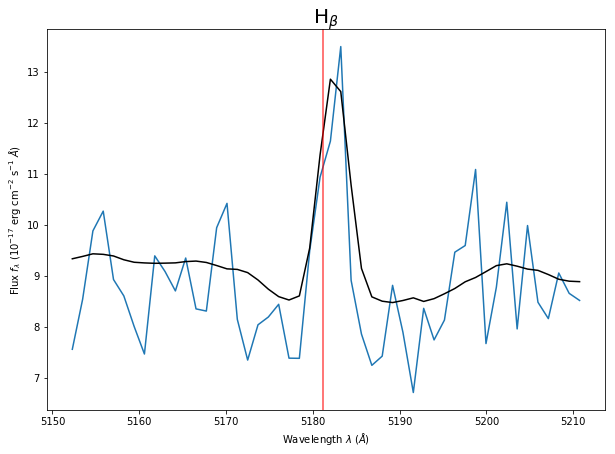

In [10]:
width = 30
fig = plt.figure(figsize=(10, 7))
count = 1
line = lines_shifted[count] #H_beta
wf = [(w, f, m) for w, f, m in zip(wl, flux, model) if (w<line+width) and (w>line-width)]
wlcut = [tup[0] for tup in wf]
fluxcut = [tup[1] for tup in wf]
modelcut = [tup[2] for tup in wf]

plt.title(labels[count], size=20)
plt.plot(wlcut, fluxcut)
plt.plot(wlcut, modelcut, color='black')
plt.axvline(line, color='red', alpha=0.7)
plt.xlabel('Wavelength $\lambda$ ($\AA$)')
plt.ylabel('Flux $f_\lambda$ ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA$)')